## What we are going to do?


1. Download the IMDB review dataset
2. Perform necessary preprocessing
3. Convert data into vector (OHE,word2vec,BOW)
4. create a model(RNN, LSTM,Bi-directional LSTM, Stacked LSTM, GRU) using keras, tensorflow or pytorch
5. Compare the performance, which model is Best?### Note: The datset has been taken from: https://ai.stanford.edu/~amaas/data/sentiment/

In [78]:
import tarfile
import os

In [2]:
# path_tofile = r"/Users/praveensrivas/Documents/NLP_GEN_AI/Projects/Data/aclImdb_v1.tar.gz"
# extract_to  = os.path.dirname(path_tofile)


# if tarfile.is_tarfile(path_tofile):
#   with tarfile.open(path_tofile) as f:
#     f.extractall(path=extract_to)    #extract

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)  # or 1000
# pd.set_option('display.max_rows', None)  # or 1000
# pd.set_option('display.max_colwidth', None)  # or 199

#### 1. Reading data, and creating train test dataset

In [4]:
def load_data_from_folder(folder_path, label):
  data = []
  for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
      file_path = os.path.join(folder_path, filename)
      with open(file_path,'r',encoding='utf-8') as file:
        content = file.read()
        data.append((content,label))

  return data

def create_dataset(base_dir):
  train_data = []
  test_data = []

  #Train paths
  train_pos_path = os.path.join(base_dir,'train','pos')
  train_neg_path = os.path.join(base_dir,'train','neg')


  #Test path
  test_pos_path = os.path.join(base_dir,'test','pos')
  test_neg_path = os.path.join(base_dir,'test','neg')


  # Load train data
  train_data.extend(load_data_from_folder(train_pos_path,1))
  train_data.extend(load_data_from_folder(train_neg_path,0))

  # Load test data
  test_data.extend(load_data_from_folder(test_pos_path,1))
  test_data.extend(load_data_from_folder(test_neg_path,0))

  # Convert to Dataframe
  train_df = pd.DataFrame(train_data, columns=['review','label'])
  test_df = pd.DataFrame(test_data, columns=['review','label'])

  return train_df, test_df

In [5]:
base_dir = '/Users/praveensrivas/Documents/Datasets/NLP_Datasets/Data/aclImdb'

In [6]:
train_df, test_df = create_dataset(base_dir=base_dir)

In [7]:
train_df.sample(2)

,review,label
9274,"This may not be a memorable classic, but it is...",1
14707,I own 2 home entertainment stores and I've see...,0


## 2. Text preprocessing
1. Lowercasing  
2. Remove Punctuation  
3. Tokenization  
4. Remove Stopwords  
5. Remove Numbers  
6. Stemming  
7. Lemmatization  
8. Handling Special Characters  
9. Handling Whitespace

In [8]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load stopwords
stopwords_ = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text by applying the following steps:
    1. Convert to lowercase
    2. Remove punctuation marks, HTML tags, and URLs
    3. Tokenize and remove stopwords
    4. Lemmatize words
    
    Args:
        text (str): The input text to be processed.
        
    Returns:
        str: Cleaned and lemmatized text without stopwords.
    """
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags, content in brackets, URLs, and special characters
    text = re.sub(r'<[^>]*?>|\[.*?\]|https?:\/\/\S+|www\.\S+|[^\w\s]', '', text)
    
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords_]
    
    # Lemmatize words
    wl = WordNetLemmatizer()
    text = " ".join([wl.lemmatize(word) for word in tokens])
    
    return text


In [9]:
train_df['clean_review'] = train_df['review'].apply(preprocess_text)

In [10]:
test_df['clean_review'] = test_df['review'].apply(preprocess_text)

In [11]:
train_df.drop(columns=["review"], inplace=True)
test_df.drop(columns=["review"], inplace=True)

In [12]:
# checking AVG words in reviews
word_count = train_df['clean_review'].apply(lambda x: len(x.split()))
word_count.describe()

count    25000.000000
mean       121.167120
std         91.157393
min          4.000000
25%         65.000000
50%         90.000000
75%        148.000000
max       1429.000000
Name: clean_review, dtype: float64

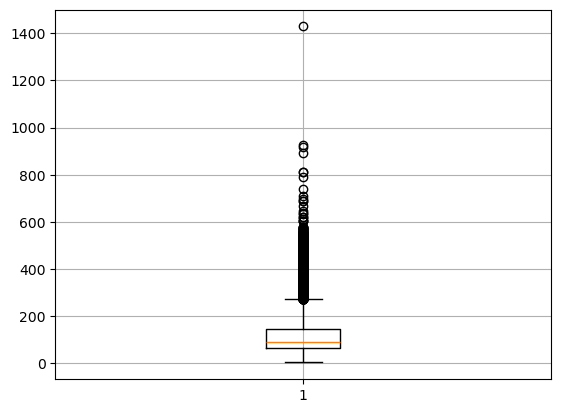

In [13]:
# box plot for wordcount
import matplotlib.pyplot as plt
plt.boxplot(word_count)
plt.grid(True)
plt.show()

`Observation: ` Most of the word count in each review is less then 200

### Word cloud for Positive and Negative

In [14]:
from wordcloud import WordCloud

pos_word_list = train_df[train_df['label']==1]['clean_review'].unique().tolist()
neg_word_list = train_df[train_df['label']==0]['clean_review'].unique().tolist()

pos_wordcloud = " ".join(pos_word_list)
neg_wordcloud = " ".join(neg_word_list)

pos_wordcloud_plot = WordCloud(width=800, height=600, stopwords=stopwords_).generate(pos_wordcloud)
neg_wordcloud_plot = WordCloud(width=800, height=600, stopwords=stopwords_).generate(neg_wordcloud)


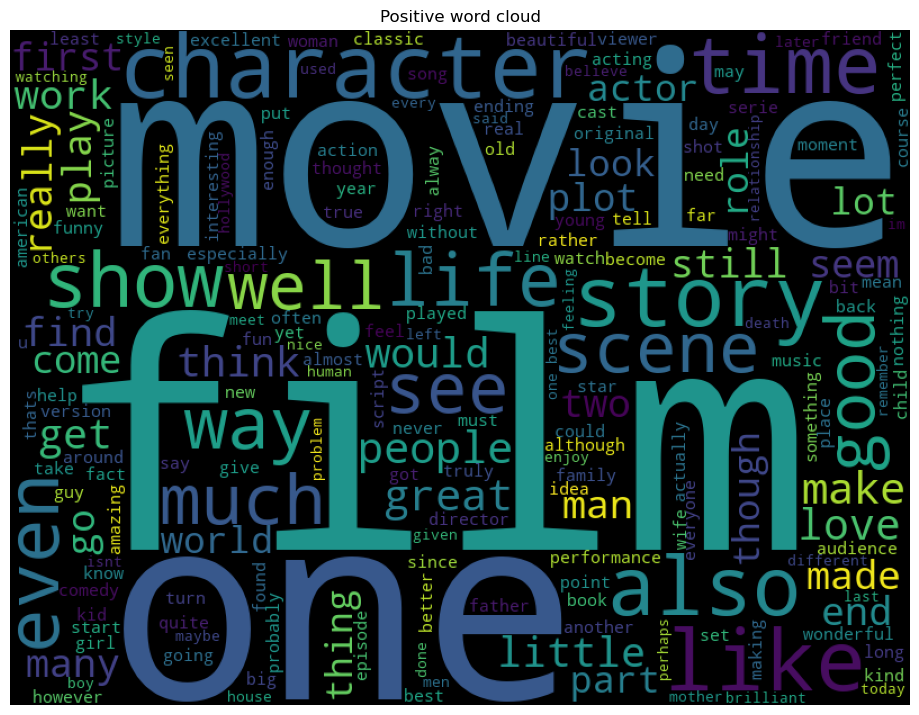

In [15]:
plt.figure(figsize=(9,9), facecolor=None)
plt.title("Positive word cloud")
plt.imshow(pos_wordcloud_plot)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

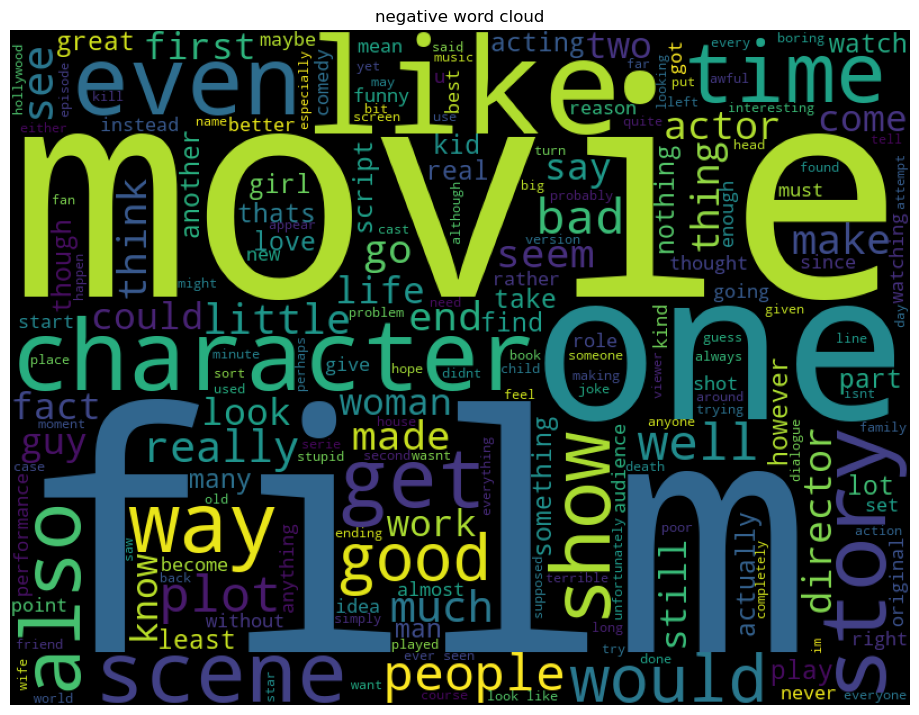

In [16]:
plt.figure(figsize=(9,9), facecolor=None)
plt.title("negative word cloud")
plt.imshow(neg_wordcloud_plot)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Encoding/Embedding:
- Here we need to encode the sentence for understanding the context of the each review, hence we are going to use the sentence level embedding.
- Doc2Vec (Paragraph Vector):
  
    - Description: Learns fixed-length vector representations for entire documents.
    Best for: Long documents where a single global representation is sufficient.
    - Pros:
    Captures document-level semantics.
    - Cons:
    Less effective for tasks requiring fine-grained understanding.

- Word2Vec (Pretrained Word Embeddings):
  
    - Description: Maps words into dense vector spaces. For long text, embeddings can be averaged or concatenated.
    Best for: Moderate-length text with manageable computational resources.
    - Pros:
    Captures semantic relationships.
    Can handle longer text better than bag-of-words methods.
    - Cons:
    Loses information about word order.

In [17]:
## Word2Vec
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from nltk import sent_tokenize


wv = api.load('word2vec-google-news-300') # better Keep it commented to prevent reload 
train_sent = []
corpus = train_df['clean_review'].tolist()
corpus
# raw_sent = sent_tokenize(corpus)

for sent in corpus:
  train_sent.append(sent)
train_sent = [x.split() for x in train_sent]
custom_word2vec = Word2Vec(window=3, min_count=5,vector_size=300,sg=1)
custom_word2vec.build_vocab(train_sent)
custom_word2vec.train(train_sent, total_examples=len(train_sent), epochs=10)

(27456255, 30291780)

In [18]:
print(custom_word2vec.corpus_count)
custom_word2vec.wv['scripting'].shape

25000


(300,)

In [19]:
vocab = list(custom_word2vec.wv.index_to_key)
vocab[:10]

['movie',
 'film',
 'one',
 'like',
 'time',
 'good',
 'character',
 'story',
 'get',
 'even']

In [20]:
custom_word2vec.wv.most_similar("story")

[('storyline', 0.5676624774932861),
 ('storyit', 0.5592465400695801),
 ('thingthe', 0.5449621081352234),
 ('lovestory', 0.5321277379989624),
 ('bethe', 0.5315364599227905),
 ('storya', 0.5282101631164551),
 ('distort', 0.5252962112426758),
 ('ideathe', 0.5218384265899658),
 ('cq', 0.516707181930542),
 ('tale', 0.5149734020233154)]

In [21]:
custom_word2vec.wv.most_similar("kill")

[('killing', 0.4564180076122284),
 ('kabal', 0.4545617699623108),
 ('befriend', 0.4432491958141327),
 ('sicko', 0.4409029483795166),
 ('dispatch', 0.43973347544670105),
 ('emo', 0.43519940972328186),
 ('slay', 0.4313916563987732),
 ('infect', 0.42579594254493713),
 ('herand', 0.4254298806190491),
 ('strangle', 0.42418891191482544)]

In [22]:
custom_word2vec.wv.most_similar("comedy")

[('slapstick', 0.5298362970352173),
 ('satire', 0.49900922179222107),
 ('comedic', 0.4936986565589905),
 ('screwball', 0.4883802831172943),
 ('standup', 0.4851530194282532),
 ('masala', 0.47538188099861145),
 ('humor', 0.4742293655872345),
 ('comedian', 0.469491571187973),
 ('humour', 0.46209394931793213),
 ('askeys', 0.4587768614292145)]

In [23]:
custom_word2vec.wv.most_similar("drama")

[('whodunnit', 0.46126431226730347),
 ('characterdriven', 0.4459489583969116),
 ('flourished', 0.4433059096336365),
 ('dramatised', 0.44024020433425903),
 ('unpredictability', 0.439441442489624),
 ('frivolity', 0.43785372376441956),
 ('dramatization', 0.43528902530670166),
 ('dramathe', 0.435089647769928),
 ('sliceoflife', 0.43294262886047363),
 ('wellsuited', 0.4317241907119751)]

### Preprocess train data

In [24]:
# importing the required libs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [25]:
X_train = train_df['clean_review'].tolist()
y_train = train_df['label'].values

# Tokenize the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)

In [26]:
print(X_train[0],X_train_seq[0],sep='\n')

movie get respect sure lot memorable quote listed gem imagine movie joe piscopo actually funny maureen stapleton scene stealer moroni character absolute scream watch alan skipper hale jr police sgt
[1, 9, 947, 156, 61, 763, 1947, 3243, 1173, 709, 1, 764, 12763, 73, 80, 6534, 13793, 15, 16491, 31543, 7, 1369, 1279, 33, 1451, 16492, 7918, 1592, 453, 6279]


In [28]:
# Pading the sequence to max length for similar length of embedding
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq,maxlen=max_length, padding='post')

In [29]:
print(max_length)

1429


### Preprocess the test data

In [30]:
X_test = test_df['clean_review'].tolist()
y_test = test_df['label'].values

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq,maxlen=max_length,padding='post')

### Prepare the Embedding matrix

In [31]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 300  #same as word2vec custom model dimension

embedding_matrix = np.zeros((vocab_size,embedding_dim))
for word, i in tokenizer.word_index.items():
  if word in custom_word2vec.wv:
    embedding_matrix[i]=custom_word2vec.wv[word]

In [32]:
print(embedding_matrix[1])

[ 1.52240200e-02  8.65985528e-02 -3.12849283e-02 -4.60420875e-03
 -1.99542180e-01 -1.16699100e-01  1.44159064e-01  1.43240765e-01
 -1.18863601e-02 -5.64789474e-02  2.47201994e-01  1.38608411e-01
 -2.14453548e-01 -9.11394879e-03 -1.91885650e-01 -1.51884332e-01
  3.42544258e-01 -1.44340187e-01 -2.22689122e-01 -1.76238388e-01
  1.80883944e-01 -8.44965037e-03  1.16893798e-02 -4.15395908e-02
 -2.27729455e-02  5.43073490e-02 -2.21427642e-02  1.28763139e-01
  2.28278432e-02 -1.58052877e-01 -7.09937885e-02 -1.24859735e-01
  8.69581997e-02  1.03759453e-01 -3.99977118e-02  1.86729297e-01
  2.25825220e-01 -2.81982034e-01 -3.37407291e-02 -5.34376577e-02
 -1.50674954e-01  8.52214769e-02 -1.33445421e-02 -3.40135843e-02
  8.58742557e-03  1.36280060e-01 -1.29000738e-01  2.04819500e-01
 -1.31647676e-01  4.54123765e-02  9.77953672e-02  1.58842638e-01
 -2.26136133e-01  7.24365935e-02 -1.69086918e-01  2.36187363e-03
  7.40113333e-02 -1.23372898e-01  3.10325027e-01  1.30615652e-01
 -3.15196887e-02 -8.35775

### Checking Mac ready for training the model on M3 chip

In [33]:
# !pip install tensorflow-macos
# !pip install tensorflow-metal
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import tensorflow as tf
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

import tensorflow as tf

# Set memory growth for GPUs before initializing TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("\nMemory growth set for GPUs")
    except RuntimeError as e:
        print("\nError:", e)
else:
    print("Model will use CPU")


Num GPUs Available:  1

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}

Memory growth set for GPUs


## Check imbalance data

In [49]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([1., 1.])

In [37]:
# dummy_model = Sequential([Dense(10, input_shape=(20,), activation='relu'), Dense(1, activation='sigmoid')])
# dummy_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# dummy_model.fit(np.random.random((100, 20)), np.random.randint(0, 2, (100,)), epochs=5, verbose=1)


### Building RNN model

In [68]:
# Importing required libs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [82]:
# model initialize
model = Sequential()
# Embedding Layer
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_length,
                    trainable=True))  

# # Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(50, return_sequences=True)))

# Another LSTM layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.5))

# Fully Connected Dense Layer
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

In [83]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │    39,951,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,951,300 (152.40 MB)

 Trainable params: 39,951,300 (152.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# training a model
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_data=(X_test_padded,y_test),callbacks=[early_stopping])

Epoch 1/10
  4/391 ━━━━━━━━━━━━━━━━━━━━ 2:14 348ms/step - accuracy: 0.4844 - loss: 1.4034

# conclusion:
This above Model is performing bad, after making the model more complex, Let's improve by doing the embedding by using another techinque

---

# Now we will be using the embedding 